In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import metrics 

In [1]:
if 1:

  import zipfile

  zip_file = '/content/drive/MyDrive/train_dataset_train.zip'

  z = zipfile.ZipFile(zip_file, 'r')
  z.extractall('/content/drive/MyDrive/tmp')
  zip_file_t = '/content/drive/MyDrive/test_dataset_test.zip'

  z = zipfile.ZipFile(zip_file_t, 'r')
  z.extractall('/content/drive/MyDrive/tmp')

  print(os.listdir())
  print(os.listdir('./drive/MyDrive/tmp'))


Creating a TensorFlow Dataset


In [ ]:
IMAGE_SIZE = 512
BATCH_SIZE = 5
NUM_CLASSES = 1
DATA_DIR = './drive/MyDrive/tmp/train_dataset_train/train_wall'
NUM_TRAIN_IMAGES = 2800
NUM_VAL_IMAGES = 700


train_images = sorted(glob(os.path.join(DATA_DIR, 'image/*')))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, "mask/*")))[:NUM_TRAIN_IMAGES]
val_images = sorted(glob(os.path.join(DATA_DIR, "image/*")))[
    NUM_TRAIN_IMAGES:NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]
val_masks = sorted(glob(os.path.join(DATA_DIR, "mask/*")))[
    NUM_TRAIN_IMAGES:NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
   ]

def read_image(image_path, mask=False):

  image = tf.io.read_file(image_path)
  if mask:
      image = tf.image.decode_png(image, channels=1)
      image.set_shape([None, None, 1])
      image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
  else:
      image = tf.image.decode_png(image, channels=3)
      image.set_shape([None, None, 3])
      image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
      image = image / 127.5 - 1
  return image


def load_data(image_list, mask_list):

  image = read_image(image_list)
  mask = read_image(mask_list, mask=True)
  return image, mask

def augment(image, label):
  #   #img = tf.image.rot90(image)
  img = tf.image.random_hue(image, 0.5)
  img = tf.image.random_saturation(img, 0.2, 0.8)
  img = tf.image.random_contrast(img, 0.2, 0.8)
  img = tf.image.random_brightness(img, 0.2, 0.8)
  
  return (img, label)


def data_generator(image_list, mask_list):

  dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
  dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
  dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
  return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(5, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(5, 512, 512, 1), dtype=tf.float32, name=None))>
Val Dataset: <BatchDataset element_spec=(TensorSpec(shape=(5, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(5, 512, 512, 1), dtype=tf.float32, name=None))>


Building the DeepLabV3+ model
DeepLabv3+ extends DeepLabv3 by adding an encoder-decoder structure. 

In [ ]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [ ]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model_1 = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model_1.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

Training
We train the model using sparse categorical crossentropy as the loss function, and Adam as the optimizer.

In [ ]:
class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, smooth=1e-6, gama=2):
        super(DiceLoss, self).__init__()
        self.name = 'NDL'
        self.smooth = smooth
        self.gama = gama

    def call(self, y_true, y_pred):
        y_true, y_pred = tf.cast(
            y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
        nominator = 2 * \
            tf.reduce_sum(tf.multiply(y_pred, y_true)) + self.smooth
        denominator = tf.reduce_sum(
            y_pred ** self.gama) + tf.reduce_sum(y_true ** self.gama) + self.smooth
        result = 1 - tf.divide(nominator, denominator)
        return result
#metrics =DiceLoss()

In [ ]:
#model_1.save('./drive/MyDrive/tmp/model_1')
#model_1 = keras.models.load_model('./drive/MyDrive/tmp/model_1', compile=False)
# # # model_1.evaluate(x_test, y_test)

In [ ]:
#BATCH_SIZE = 5

In [ ]:
loss = DiceLoss()
model_1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss, metrics= ["binary_accuracy"],   
    )

history = model_1.fit(train_dataset, validation_data=val_dataset, epochs=1)

Epoch 1/2
101/560 [====>.........................] - ETA: 4:30:26 - loss: 0.6825 - binary_accuracy: 0.7839

1/1 [==============================] - 2s 2s/step
(512, 512)


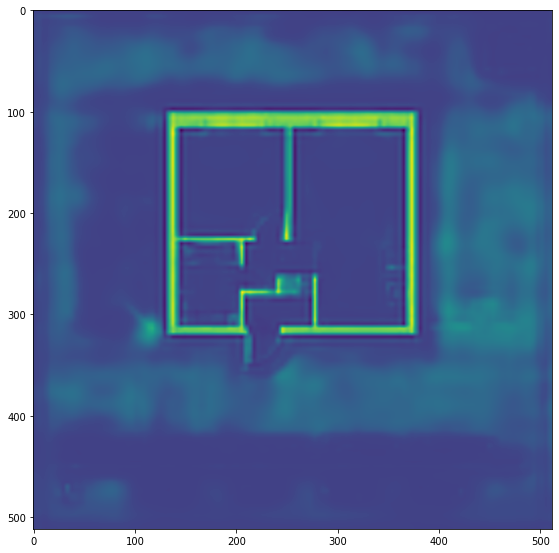

In [ ]:
def read_image(image_path, mask=False):

  image = tf.io.read_file(image_path)
  if mask:
    image = tf.image.decode_png(image, channels=1)
    image.set_shape([None, None, 1])
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
  else:
    image = tf.image.decode_png(image, channels=3)
    image.set_shape([None, None, 3])
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = image / 127.5 - 1
  return image

image_tensor = read_image("./drive/MyDrive/tmp/test_dataset_test/00388128-357d-44bb-a630-5e8856e4dcb0.png")
predictions_1 = model_1.predict(np.expand_dims((image_tensor), axis=0))
predictions_1 = np.squeeze(predictions_1)
predictions_1.shape


plt.figure(figsize=(21,21))
plt.subplot(212)
im1 = plt.imshow(predictions_1)

print(predictions_1.shape)


In [ ]:
DATA_DIR = './drive/MyDrive/tmp/train_dataset_train/train_window'
train_images = sorted(glob(os.path.join(DATA_DIR, 'image/*')))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, "mask/*")))[:NUM_TRAIN_IMAGES]
val_images = sorted(glob(os.path.join(DATA_DIR, "image/*")))[
    NUM_TRAIN_IMAGES:NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]
val_masks = sorted(glob(os.path.join(DATA_DIR, "mask/*")))[
    NUM_TRAIN_IMAGES:NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
   ]

In [ ]:
train_dataset_2= data_generator(train_images, train_masks)
val_dataset_2 = data_generator(val_images, val_masks)

In [ ]:
model_2 = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
loss = DiceLoss()
model_2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss, metrics= ["binary_accuracy"],   
    )

history = model_2.fit(train_dataset_2, validation_data=val_dataset_2, epochs=2)

In [ ]:
#model_2.save('./drive/MyDrive/tmp/model_2')
#model_2 = keras.models.load_model('./drive/MyDrive/tmp/model_2')
# model_2.evaluate(x_test, y_test)

1/1 [==============================] - 1s 860ms/step
(512, 512)


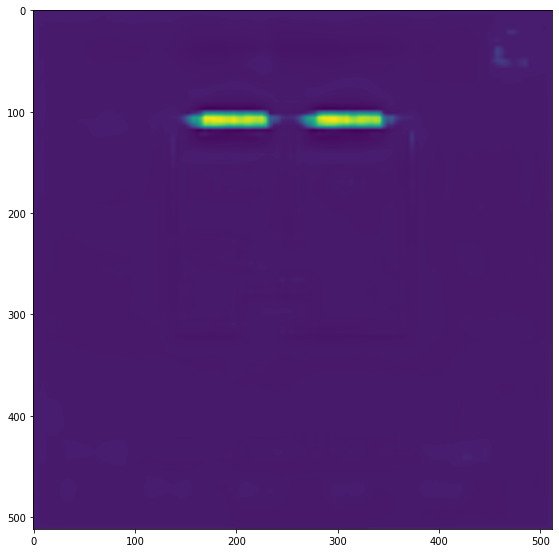

In [ ]:
def read_image(image_path, mask=False):

  image = tf.io.read_file(image_path)
  if mask:
    image = tf.image.decode_png(image, channels=1)
    image.set_shape([None, None, 1])
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
  else:
    image = tf.image.decode_png(image, channels=3)
    image.set_shape([None, None, 3])
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = image / 127.5 - 1
  return image

image_tensor = read_image("./drive/MyDrive/tmp/test_dataset_test/00388128-357d-44bb-a630-5e8856e4dcb0.png")
predictions_2 = model_2.predict(np.expand_dims((image_tensor), axis=0))
predictions_2 = np.squeeze(predictions_2)
#predictions = np.argmax(predictions) #, axis=2)
print(predictions_2.shape)
# predict = tf.nn.sigmoid(predictions) > 0.2  #predict = torch.sigmoid(predict) > 0.2
# res = mask_to_grayscale(predictions[0])

plt.figure(figsize=(21,21))
plt.subplot(212)
im1 = plt.imshow(predictions_2)


Объявляем класс, используемый для обучения

In [ ]:
!pip install python-dotenv==0.19.0 tqdm==4.62.2 numpy Pillow==7.0.0 matplotlib==3.4.3 opencv-python==4.6.0.66 opencv-python-headless==4.6.0.66 matplotlib
!pip install scikit-learn==0.24.2 torch==1.12.1 torchvision==0.13.1 pytorch-ignite segmentation-models-pytorch==0.2.0 albumentations==1.0.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.4.3-cp37-cp37m-manylinux1_x86_64.whl (10.3 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.24.2 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn


from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, Metric
from ignite.engine import _prepare_batch

from tqdm import tqdm

import json
import base64
import os
import glob
import numpy as np
import cv2

from PIL import Image
import segmentation_models_pytorch as smp

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from typing import Callable, Tuple, Dict, Any, List, Sequence, Iterator, Optional
from collections import defaultdict
from torchvision.models.detection.faster_rcnn import fasterrcnn_resnet50_fpn, FastRCNNPredictor

In [ ]:
class DetectionTrainer:

    def __init__(self, model: nn.Module, optimizer: torch.optim.Optimizer,
                 device: str, metric_functions: List[Tuple[str, Callable]] = [],
                 callbacks: List[Callable[[nn.Module, int], None]] = [], epoch_number: int = 0):
        self.model = model
        self.optimizer = optimizer

        self.device = device

        self.metric_functions = metric_functions
        self.callbacks = callbacks

        self.epoch_number = epoch_number

    @torch.no_grad()
    def evaluate_batch(self, val_iterator: Iterator, eval_on_n_batches: int) -> Optional[Dict[str, float]]:
        predictions = []
        targets = []

        for real_batch_number in range(eval_on_n_batches):
            try:
                xs, ys = next(val_iterator)

                xs = torch.tensor(xs, device=self.device)
                ys = [{key: torch.tensor(y[key], device=self.device) for key in y} for y in ys]
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break

            ys_pred = self.model.eval()(xs)

            for y_pred, y_true in zip(ys_pred, ys):
                predictions.append({key: y_pred[key].cpu().numpy() for key in y_pred})
                targets.append({key: y_true[key].cpu().numpy() for key in y_true})

        metrics = {}

        predictions_tensor = []
        targets_tensor = []

        for y_pred, y_true in zip(predictions, targets):
            predictions_tensor.append({key: torch.tensor(y_pred[key], device=self.device) for key in y_pred})
            targets_tensor.append({key: torch.tensor(y_true[key], device=self.device) for key in y_true})

        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets).item()

        return metrics

    @torch.no_grad()
    def evaluate(self, val_loader: DataLoader, eval_on_n_batches: int = 1) -> Dict[str, float]:
        metrics_sum = defaultdict(float)
        num_batches = 0

        val_iterator = iter(val_loader)

        while True:
            batch_metrics = self.evaluate_batch(val_iterator, eval_on_n_batches)

            if batch_metrics is None:
                break

            for metric_name in batch_metrics:
                metrics_sum[metric_name] += batch_metrics[metric_name]

            num_batches += 1

        metrics = {}

        for metric_name in metrics_sum:
            metrics[metric_name] = metrics_sum[metric_name] / num_batches

        return metrics

    def fit_batch(self, train_iterator: Iterator, update_every_n_batches: int) -> Optional[Dict[str, float]]:
        self.optimizer.zero_grad()

        predictions = []
        targets = []

        for real_batch_number in range(update_every_n_batches):
            try:
                xs, ys = next(train_iterator)
                xs = torch.tensor(xs, device=self.device)
                ys = [{key: torch.tensor(y[key], device=self.device) for key in y} for y in ys]
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break

            loss = sum(self.model.train()(xs, ys).values())

            (loss / update_every_n_batches).backward()

            with torch.no_grad():
                ys_pred = self.model.eval()(xs)

                for y_pred, y_true in zip(ys_pred, ys):
                    predictions.append({key: y_pred[key].cpu().numpy() for key in y_pred})
                    targets.append({key: y_true[key].cpu().numpy() for key in y_true})

        self.optimizer.step()

        metrics = {}

        predictions_tensor = []
        targets_tensor = []

        for y_pred, y_true in zip(predictions, targets):
            predictions_tensor.append({key: torch.tensor(y_pred[key], device=self.device) for key in y_pred})
            targets_tensor.append({key: torch.tensor(y_true[key], device=self.device) for key in y_true})

        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets).item()

        return metrics

    def fit_epoch(self, train_loader: DataLoader, update_every_n_batches: int = 1) -> Dict[str, float]:
        metrics_sum = defaultdict(float)
        num_batches = 0

        train_iterator = iter(train_loader)

        while True:
            batch_metrics = self.fit_batch(train_iterator, update_every_n_batches)

            if batch_metrics is None:
                break

            for metric_name in batch_metrics:
                metrics_sum[metric_name] += batch_metrics[metric_name]

            num_batches += 1

        metrics = {}

        for metric_name in metrics_sum:
            metrics[metric_name] = metrics_sum[metric_name] / num_batches

        return metrics

    def fit(self, train_loader: DataLoader, num_epochs: int,
            val_loader: DataLoader = None, update_every_n_batches: int = 1
            ) -> Dict[str, np.ndarray]:
        summary = defaultdict(list)

        def save_metrics(metrics: Dict[str, float], postfix: str = '') -> None:
            nonlocal summary, self

            for metric in metrics:
                metric_name, metric_value = f'{metric}{postfix}', metrics[metric]

                summary[metric_name].append(metric_value)

                print(f"{metric_name}: {metric_value}, Epoch: {self.epoch_number}")

        for _ in tqdm(range(num_epochs - self.epoch_number), initial=self.epoch_number, total=num_epochs):
            self.epoch_number += 1

            train_metrics = self.fit_epoch(train_loader, update_every_n_batches)

            with torch.no_grad():
                save_metrics(train_metrics, postfix='_train')

                if val_loader is not None:
                    test_metrics = self.evaluate(val_loader)
                    save_metrics(test_metrics, postfix='_test')

                with torch.no_grad():
                    for callback in self.callbacks:
                        callback(self.model, self.epoch_number)

        summary = {metric: np.array(summary[metric]) for metric in summary}

        return summary

Инициализация модели обучения и функций для подсчета метрик качества обучения нейросетей

In [ ]:
def initialize_model(num_classes: int,
                     min_size: int, max_size: int,
                     image_mean: Sequence[float], image_std: Sequence[float],
                     device: str = None) -> torch.nn.Module:
    pretrained_model = fasterrcnn_resnet50_fpn(pretrained=False, min_size=min_size, max_size=max_size,
                                               image_mean=image_mean, image_std=image_std)
    num_predictor_features = pretrained_model.roi_heads.box_head.fc7.out_features
    pretrained_model.roi_heads.box_predictor = FastRCNNPredictor(num_predictor_features, num_classes)

    return pretrained_model.to(device)


def compute_iou(box1: torch.tensor, box2: torch.tensor) -> torch.tensor:
    x1 = max(box1[0], box2[0])
    x2 = min(box1[2], box2[2])
    y1 = max(box1[1], box2[1])
    y2 = min(box1[3], box2[3])

    if x2 - x1 < 0 or y2 - y1 < 0:
        return 0

    intersection = (x2 - x1) * (y2 - y1)
    sum_ = ((box1[2] - box1[0]) * (box1[3] - box1[1]) +
            (box2[2] - box2[0]) * (box2[3] - box2[1]))

    iou = intersection / (sum_ - intersection)

    return iou.item()


class MeanAveragePrecision:

    def __init__(self, num_conf: int = 11):
        self.num_conf = num_conf

    @staticmethod
    def is_true(box: torch.tensor, label: int,
                y_true: Dict[str, torch.tensor],
                iou_thresh: float = 0.5) -> bool:
        num_true = len(y_true['boxes'])

        for i in range(num_true):
            if label == y_true['labels'][i]:
                if compute_iou(box, y_true['boxes'][i]) > iou_thresh:
                    return True
        return False

    @staticmethod
    def compute_map_given_conf(y_preds: List[Dict[str, torch.tensor]],
                               y_trues: List[Dict[str, torch.tensor]],
                               conf: float) -> float:
        num_pos = defaultdict(int)
        num_true_pos = defaultdict(int)

        for y_pred, y_true in zip(y_preds, y_trues):

            num_pred = len(y_pred['boxes'])

            for i in range(num_pred):
                if y_pred['scores'][i] > conf:
                    label = y_pred['labels'][i]
                    num_pos[label] += 1

                    if MeanAveragePrecision.is_true(y_pred['boxes'][i], y_pred['labels'][i], y_true):
                        num_true_pos[label] += 1

        all_classes_sum = sum(num_true_pos[lbl] / num_pos[lbl] for lbl in num_pos)

        try:
            precision = all_classes_sum / len(num_pos)
        except ZeroDivisionError:
            precision = 0

        return precision

    def __call__(self, y_pred: List[Dict[str, torch.tensor]],
                 y_true: List[Dict[str, torch.tensor]]) -> float:
        assert len(y_pred) == len(y_true)

        map_sum = 0

        for conf in np.linspace(0, 1, self.num_conf):
            map_sum += self.compute_map_given_conf(y_pred, y_true, conf)

        return torch.tensor(map_sum / self.num_conf)


def minimum_bounding_box(points: List[List[float]]) -> Tuple[float, float, float, float]:
    x_min = min(p[0] for p in points)
    y_min = min(p[1] for p in points)
    x_max = max(p[0] for p in points)
    y_max = max(p[1] for p in points)

    return x_min, y_min, x_max, y_max


Классы, для формирования датасетов(для обучения и для тестирования

In [ ]:
class DataRetriever:

    def __init__(self,
                 dataset_path: str):
        super().__init__()

        self.dataset_path = dataset_path
        self.samples_paths = self.load_paths()
        print(f'Found {len(self.samples_paths)} samples')

    def remove_path(self, idx):
        del self.samples_paths[idx]

    def load_paths(self) -> List[str]:
        samples_paths = []

        for object_ in tqdm(os.listdir(self.dataset_path)):
            ext = object_.split(".")[-1]

            if ext != 'json':
                continue

            samples_paths.append(self.dataset_path + "/" + object_)

        return samples_paths

    def num_paths(self) -> int:
        return len(self.samples_paths)


class PLRCDataset(Dataset):

    def __init__(self, data_retriever,
                 class_ids: Dict,
                 transform: A.BasicTransform = None,
                 remove_unannotated: bool = False):
        self.data_retriever = data_retriever

        self.class_ids = class_ids

        self.transform = transform

        if remove_unannotated:
            print("Removing unannotated samples")
            num_removed = self.remove_unannotated_paths()
            print(f"Removed {num_removed} unannotated samples")

    def make_layout(self, shapes: List[Dict], image_size: Tuple[int, int]) -> Dict[str, np.ndarray]:
        shapes = self.select_shapes(shapes)

        boxes = []
        labels = []

        for shape in shapes:
            if len(shape['points']) < 2:
                continue

            label = shape['label']

            if label not in self.class_ids:
                continue

            x1, y1, x2, y2 = minimum_bounding_box(shape['points'])

            x1 = max(x1, 0)
            y1 = max(y1, 0)
            x2 = min(x2, image_size[1] - 1)
            y2 = min(y2, image_size[0] - 1)

            if x1 == x2 or y1 == y2:
                continue

            boxes.append((x1, y1, x2, y2))
            labels.append(self.class_ids[label])

        if len(boxes) > 0:
            boxes = np.array(boxes)
            labels = np.array(labels, dtype=np.int64)
        else:
            boxes = np.empty((0, 4))
            labels = np.empty(0, dtype=np.int64)

        return {'boxes': boxes, 'labels': labels}

    @staticmethod
    def select_shapes(shapes: List[Dict]) -> List[Dict]:
        good_shapes = []

        for shape in shapes:
            if shape['shape_type'] not in {'polygon', 'rectangle'} or len(shape['points']) < 2:
                continue

            good_shapes.append(shape)

        return good_shapes

    def remove_unannotated_paths(self) -> int:
        counter = 0

        for i in tqdm(range(len(self) - 1, -1, -1)):
            _, y = self[i]
            if len(y['boxes']) == 0:
                self.data_retriever.remove_path(i)
                counter += 1

        return counter

    @staticmethod
    def decode_image(encoded_image: str) -> np.ndarray:
        bytearray_ = np.asarray(bytearray(base64.b64decode(encoded_image)), dtype=np.uint8)
        return cv2.imdecode(bytearray_, cv2.IMREAD_COLOR).astype(np.float32) / 255

    def read_sample(self, json_path) -> Tuple[np.ndarray, Dict[str, np.ndarray]]:
        with open(json_path, 'r') as f:
            json_contents = json.load(f)

        image = self.decode_image(json_contents['imageData'])
        layout = self.make_layout(json_contents['shapes'], image.shape[:2])

        return image, layout

    def __getitem__(self, idx):
        sample_path = self.data_retriever.samples_paths[idx]

        x, y = self.read_sample(sample_path)

        if self.transform is not None:
            transformed = self.transform(image=x, bboxes=y['boxes'], labels=y['labels'])
            x, y['boxes'], y['labels'] = transformed['image'], transformed['bboxes'], transformed['labels']

        return x, y

    def __len__(self):
        return self.data_retriever.num_paths()


class DatasetPart(Dataset):

    def __init__(self, dataset: Dataset,
                 indices: np.ndarray,
                 transform: A.BasicTransform = None):
        self.dataset = dataset
        self.indices = indices

        self.transform = transform

    def __getitem__(self, idx: int) -> Any:
        x, y = self.dataset[self.indices[idx]]

        if self.transform is not None:
            transformed = self.transform(image=x, bboxes=y['boxes'], labels=y['labels'])
            x, y['boxes'], y['labels'] = transformed['image'], transformed['bboxes'], transformed['labels']

        return x, y

    def __len__(self) -> int:
        return len(self.indices)


In [ ]:
config = {
  "dataset_path": "./drive/MyDrive/tmp/train_dataset_train/object_detection",
  "model_log_interval": 1,
  "data": {
    "class_ids": {
      "door": 1
    }
  },
  "model": {
    "image_size": 512
  },
  "training": {
    "num_epochs": 2,
    "batch_size": 1,
    "update_every_n_batches": 1,
    "device": "cuda",
    "learning_rate": 1e-4,
    "num_workers": 0
  }
}

In [ ]:
def make_transforms(config: Dict[str, Any]) -> Dict[str, Callable]:
    size = config['model']['image_size']

    train_list = [A.LongestMaxSize(size),
                  A.PadIfNeeded(size, size, border_mode=cv2.BORDER_REPLICATE),
                  ToTensorV2()]
    eval_list = [A.LongestMaxSize(size),
                 A.PadIfNeeded(size, size, border_mode=cv2.BORDER_REPLICATE),
                 ToTensorV2()]

    return {'train': A.Compose(train_list, bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])),
            'test': A.Compose(eval_list, bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))}


def make_datasets(transforms, config: Dict[str, Any]) -> Dict[str, Dataset]:
    all_data_retriever = DataRetriever(config['dataset_path'])

    all_data_dataset = PLRCDataset(all_data_retriever, config['data']['class_ids'], remove_unannotated=True)

    train_indices, test_indices = train_test_split(range(len(all_data_dataset)), test_size=0.3)

    return {'train': DatasetPart(all_data_dataset, train_indices, transform=transforms['train']),
            'test': DatasetPart(all_data_dataset, test_indices, transform=transforms['test'])}


def make_loaders(datasets, config: Dict[str, Any]):
    def collate_fn(samples):
        xs, ys = list(zip(*samples))

        for y in ys:
            if len(y['boxes']) == 0:
                y['boxes'] = np.empty((0, 4), dtype=np.float32)
            else:
                y['boxes'] = np.array(y['boxes'], dtype=np.float32)

            y['labels'] = np.array(y['labels'], dtype=np.int64)

        return torch.stack(xs), ys

    loaders = {}

    for name in datasets:
        loaders[name] = DataLoader(datasets[name], config['training']['batch_size'],
                                   num_workers=config['training']['num_workers'],
                                   shuffle=True, collate_fn=collate_fn)

    return loaders


def make_save_model_callback(log_interval: int):
    def save_model(model, epoch):
        if epoch % log_interval != 0:
            return
        torch.save(model.state_dict(), f"./model_obj_{epoch}")

    return save_model


if __name__ == '__main__':
    transforms = make_transforms(config)
    datasets = make_datasets(transforms, config)
    data_loaders = make_loaders(datasets, config)
    
    model = initialize_model(1 + max(config['data']['class_ids'].values()),
                             config['model']['image_size'], config['model']['image_size'], [0, 0, 0], [1, 1, 1],
                             config['training']['device'])
    optimizer = torch.optim.Adam(model.parameters(), config['training']['learning_rate'])

    metrics = [('mAP', MeanAveragePrecision())]

    trainer = DetectionTrainer(model, optimizer, metric_functions=metrics,
                               callbacks=[make_save_model_callback(config['model_log_interval'])],
                               device=config['training']['device'])

    trainer.fit(data_loaders['train'], config['training']['num_epochs'], val_loader=data_loaders['test'])

100%|██████████| 3500/3500 [00:00<00:00, 424770.37it/s]


Found 3500 samples
Removing unannotated samples


100%|██████████| 3500/3500 [02:03<00:00, 28.44it/s]
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Removed 567 unannotated samples


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


mAP_train: 0.5316280713577345, Epoch: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


mAP_test: 0.6512807289201935, Epoch: 1


 50%|█████     | 1/2 [07:39<07:39, 459.72s/it]

mAP_train: 0.6863049971561469, Epoch: 2
mAP_test: 0.7139219031330537, Epoch: 2


100%|██████████| 2/2 [15:02<00:00, 451.25s/it]


Вывод результата

In [ ]:
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.4.3
    Uninstalling matplotlib-3.4.3:
      Successfully uninstalled matplotlib-3.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.24.2 which is incompatible.


In [ ]:
import matplotlib.pyplot as plt
def draw_with_boxes(image: np.ndarray,
                    preds: Dict[str, np.ndarray] = None,
                    conf_threshold=0.5) -> np.ndarray:

    image = image.copy()

    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    font_scale = 0.7
    line_type = 1
    label_padding = 5

    num_boxes = len(preds['boxes'])

    for i in range(num_boxes):
        if preds['scores'][i] < conf_threshold:
            continue
        x_min, y_min, x_max, y_max = preds['boxes'][i]

        cv2.rectangle(img=image,
                      pt1=(int(x_min), int(y_min)),
                      pt2=(int(x_max), int(y_max)),
                      color=(0, 0, 255),
                      thickness=-1)

    return image

##Загрузка тестового изображения
image = cv2.imread("./drive/MyDrive/tmp/test_dataset_test/00388128-357d-44bb-a630-5e8856e4dcb0.png").astype(np.float32) / 255

class_ids = config['data']['class_ids']
reverse_classes_map = {v: k for k, v in class_ids.items()}
bytearray_ = np.asarray(bytearray(image), dtype=np.uint8)
x = image
transform = ToTensorV2()
model = initialize_model(1 + max(config['data']['class_ids'].values()),
                             config['model']['image_size'], config['model']['image_size'], [0, 0, 0], [1, 1, 1],
                             config['training']['device'])
model.load_state_dict(torch.load("./model_obj_2"))
x = transform(image=x)['image']
with torch.no_grad():
  y_pred = model.eval()([torch.tensor(x, device=config['training']['device'])])[0]
  y_pred = {key: y_pred[key].cpu().numpy() for key in y_pred}
  y_pred['labels'] = np.array([reverse_classes_map[label] for label in y_pred['labels']])

  x = torch.moveaxis(x, 0, -1).cpu().numpy()
  x = np.ascontiguousarray(255 * x, dtype=np.uint8)

image_with_boxes = draw_with_boxes(x, y_pred)

## Вывод реузультирующего изображения
plt.subplot(212)
im1 = plt.imshow(image_with_boxes)


NameError: ignored

In [ ]:
from tensorflow.keras.utils import save_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.utils import load_img

In [ ]:
def door_pred(image):
    image = cv2.imread('./drive/MyDrive/tmp/test_dataset_test/' + image).astype(np.float32) / 255

    class_ids = config['data']['class_ids']
    reverse_classes_map = {v: k for k, v in class_ids.items()}
    bytearray_ = np.asarray(bytearray(image), dtype=np.uint8)
    x = image
    transform = ToTensorV2()
    model = initialize_model(1 + max(config['data']['class_ids'].values()),
                                config['model']['image_size'], config['model']['image_size'], [0, 0, 0], [1, 1, 1],
                                config['training']['device'])
    model.load_state_dict(torch.load("./model_obj_2"))
    x = transform(image=x)['image']
    with torch.no_grad():
           
      y_pred = model.eval()([torch.tensor(x, device=config['training']['device'])])[0]
      y_pred = {key: y_pred[key].cpu().numpy() for key in y_pred}
      y_pred['labels'] = np.array([reverse_classes_map[label] for label in y_pred['labels']])

      x = torch.moveaxis(x, 0, -1).cpu().numpy()
      x = np.ascontiguousarray(255 * x, dtype=np.uint8)

    image_with_boxes = draw_with_boxes(x, y_pred)
    image = image_with_boxes

    #image = cv2.imread('./drive/MyDrive/tmp/base_door.png') 

    img_array = img_to_array(image)

    IMAGE_SIZE = 512
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = image / 127.5
    #plt.imshow(image)
    image.numpy()
    image = np.array(image)
    #plt.imshow(image)
    image[np.all(image != (2.0, 0.0, 0.0) , axis=-1)] = (0.0, 0.0, 0.0)
    image[np.all(image == (2.0, 2.0, 2.0) , axis=-1)] = (0.0, 0.0, 0.0)
    #plt.imshow(image)
    return image

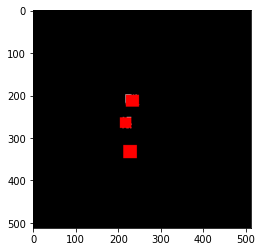

In [ ]:
door = door_pred()

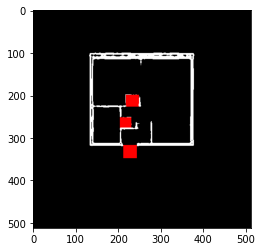

In [ ]:
plt.imshow(wall + win + door) # + img1 + img2) #, cmap='gray') 

In [ ]:
def wall_pred(img):

  image_tensor =  read_image ("./drive/MyDrive/tmp/test_dataset_test/" + img)
  pred_1 = model_1.predict(np.expand_dims((image_tensor), axis=0))
  preds_1 = np.squeeze(pred_1)
  
  img1 =  np.expand_dims((preds_1), axis=2)
  c2 = np.append(img1, img1, axis=2)
  img1 = np.append(c2, img1, axis=2)
  img1.shape     

  hsv=cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)

# Define lower and uppper limits of color
  white_lo=np.array([0,0,120])
  white_hi=np.array([0,0,255])

  # Mask image to only select 
  mask=cv2.inRange(hsv,white_lo,white_hi)
  img1[mask>0]= (200.0, 200.0, 200.0)    #(10,70,10)
  img1[np.all(img1 != (200.0, 200.0, 200.0) , axis=-1)] = (0.0, 0.0, 0.0)

  return img1

In [ ]:
def read_image(image_path, mask=False):

  image = tf.io.read_file(image_path)
  if mask:
    image = tf.image.decode_png(image, channels=1)
    image.set_shape([None, None, 1])
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
  else:
    image = tf.image.decode_png(image, channels=3)
    image.set_shape([None, None, 3])
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = image / 127.5 - 1
  return image

In [ ]:
from tensorflow.python.ops.gen_dataset_ops import parallel_interleave_dataset_v2

def win_pred(img):
    
  image_tensor = read_image('./drive/MyDrive/tmp/test_dataset_test/' + img)
  pred_2 = model_2.predict(np.expand_dims((image_tensor), axis=0))
  pred_2 = np.squeeze(pred_2)
  
  
  img2 = img_to_array(pred_2)
  c1 = np.append(img2, img2, axis=2) 
  img2 = np.append(c1, img2, axis=2)
  #print(img2.shape)
 

  hsv=cv2.cvtColor(img2,cv2.COLOR_BGR2HSV)

  white_lo=np.array([0,0, 120])
  white_hi=np.array([0, 0, 255])

  mask=cv2.inRange(hsv,white_lo,white_hi)

  img2[mask>0]= (17, 43, 163)  #(250, 2, 2)
  img2[np.all(img2 != (17.0, 43.0, 163.0) , axis=-1)] = (0.0, 0.0, 0.0)
  
  return img2

In [ ]:
if not os.path.isdir('./drive/MyDrive/tmp/solution_folder'):
    
  os.mkdir('./drive/MyDrive/tmp/solution_folder/')

SOLUTION_DIR = './drive/MyDrive/tmp/solution_folder/'

In [ ]:
IMAGE_SIZE = 512

In [ ]:
dir_list = os.listdir('./drive/MyDrive/tmp/test_dataset_test')
dir_list.sort()

for i in range(len(dir_list)):
  #print(i, dir_list[i])
  file_name = dir_list[i]
  print(file_name)
  wall = wall_pred(file_name)
  win = win_pred(file_name)
  door = door_pred(file_name)

  last_img = wall / 255 + win / 255  + door
  isWritten = cv2.imwrite(os.path.join(SOLUTION_DIR + file_name), last_img)

00388128-357d-44bb-a630-5e8856e4dcb0.png
1/1 [==============================] - 0s 23ms/step


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


003bbefa-fd50-42ed-99db-0dd36b180db9.png
1/1 [==============================] - 0s 30ms/step
0084f30c-5dc4-4e3a-a895-34676001be82.png
1/1 [==============================] - 0s 24ms/step
00a5e64d-2ca8-4083-bc5e-9c45127bba7e.png
1/1 [==============================] - 0s 24ms/step
00b645a1-8355-48f1-82cd-ccc9af33b613.png
1/1 [==============================] - 0s 27ms/step
00bcbe4d-7b94-4b06-abce-872e97cc17cd.png
1/1 [==============================] - 0s 25ms/step
00c5993e-279c-4adc-9273-da02897fa2e2.png
1/1 [==============================] - 0s 29ms/step
00ce438f-fc51-41c0-ab6f-3d6335fac59f.png
1/1 [==============================] - 0s 24ms/step
00cfd16a-f881-4ea3-bf2c-8a70abab6528.png
1/1 [==============================] - 0s 25ms/step
00e9142f-5e5b-4c8b-b833-9a9448fb5551.png
1/1 [==============================] - 0s 24ms/step
00ed5617-defe-4c77-8200-f760d8a3a30b.png
1/1 [==============================] - 0s 36ms/step
016cb44e-9416-4aca-bfe6-f48202430d1b.png
1/1 [========================